In [36]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

# Import data

In [20]:
train_path = './Output/train'
test_path = './Output/test'

In [21]:
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(train_path) if p[:14] == 'feature_vector']), \
                             *np.load(train_path + '/feature_vector0.npy').shape
print(f'Training set: {N}')

Training set: 4213


# Define data generator

In [23]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=int)

        # load individual datapoints
        for i, index in enumerate(indices):
            X[i, ] = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[0] # TODO: for now just phF

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [24]:
# train/validation split
TRAIN_VAL_SPLIT = 0.33

permutation_indices = [i for i in range(N)]
np.random.shuffle(permutation_indices)

validation_indices = permutation_indices[:int(N * TRAIN_VAL_SPLIT)]
train_indices = permutation_indices[int(N * TRAIN_VAL_SPLIT):]

print(f'|val_set|: {len(validation_indices)}, |train_set|: {len(train_indices)}')

|val_set|: 1390, |train_set|: 2823


In [32]:
# upsampling (imbalanced dataset)
y_train = np.empty((N, 2), dtype=int)

# load individual datapoints
for i in range(N):
    y_train[i] = np.load(train_path + f'/labels{i}.npy', allow_pickle=True)


positive_indices = np.where(y_train[validation_indices, 0] == 1)[0] # TODO: only phF for now
negative_indices = np.where(y_train[validation_indices, 0] == 0)[0] # TODO: only phF for now

print(f'val_set: (+: {len(positive_indices)}, -: {len(negative_indices)})\n')

positive_indices = np.where(y_train[train_indices, 0] == 1)[0] # TODO: only phF for now
negative_indices = np.where(y_train[train_indices, 0] == 0)[0] # TODO: only phF for now

print(f'train_set: (+: {len(positive_indices)}, -: {len(negative_indices)})')

negative_indices_upsampled = np.append(negative_indices,
                                       np.random.choice(negative_indices,
                                                        size=(len(positive_indices) - len(negative_indices)),
                                                        replace=True)) # with replacement

print(f'train_set (upsampled): (+: {len(positive_indices)}, -: {len(negative_indices_upsampled)})')

val_set: (+: 1028, -: 362)

train_set: (+: 2114, -: 709)
train_set (upsampled): (+: 2114, -: 2114)


# CNN

Data generators

In [33]:
training_batch_generator = DataGenerator(data_path=train_path, indices_dataset=train_indices, batch_size=128)
validation_batch_generator = DataGenerator(data_path=train_path, indices_dataset=validation_indices, batch_size=1)

Model

In [34]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(370, 100, 30), padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2')) # normal weight init + l2 regularization needed?
#model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2')) # normal weight init + l2 regularization needed?
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 370, 100, 32)      8672      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 370, 100, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 370, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 185, 50, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 185, 50, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 185, 50, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 185, 50, 32)       1

Training

In [35]:
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=20)

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
22/22 [==============================] - 96s 4s/step - loss: 6.5665 - accuracy: 0.7322 - val_loss: 5.4341 - val_accuracy: 0.7396
Epoch 2/20
22/22 [==============================] - 68s 3s/step - loss: 4.3859 - accuracy: 0.7504 - val_loss: 3.6506 - val_accuracy: 0.7396
Epoch 3/20
22/22 [==============================] - 66s 3s/step - loss: 2.9092 - accuracy: 0.7500 - val_loss: 2.5292 - val_accuracy: 0.7396
Epoch 4/20
22/22 [==============================] - 67s 3s/step - loss: 1.9970 - accuracy: 0.7582 - val_loss: 1.8487 - val_accuracy: 0.7396
Epoch 5/20
22/22 [==============================] - 68s 3s/step - loss: 1.4370 - accuracy: 0.7710 - val_loss: 1.3974 - val_accuracy: 0.7396
Epoch 6/20
22/22 [==============================] - 69s 3s/step - loss: 1.0660 - accuracy: 0.8029 - val_loss: 1.1437 - val_accuracy: 0.7396
Epoch 7/20
22/22 [==============================] - 67s 3s/step - loss: 0.8554 - accuracy: 0.7962 - val_loss: 0.9809 - val_accuracy: 0.7396
Epoch 8/20
22/22 [==

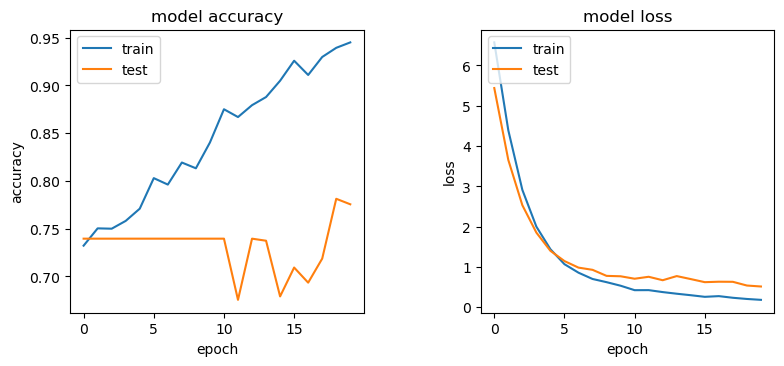

In [40]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# metric
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Evaluation

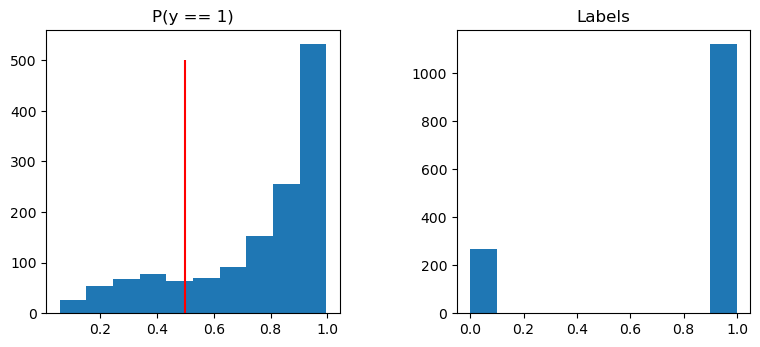

In [44]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [69]:
# load test data
N_test = sum([1 for p in os.listdir(test_path) if p[:14] == 'feature_vector'])
print(f'Test set size: {N_test}')

test_batch_generator = DataGenerator(data_path=test_path, indices_dataset=[i for i in range(N_test)], batch_size=1)
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set size: 399


In [77]:
y_test

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1.

accuracy: 0.6842105263157895
balanced accuracy:0.5116809552969994
f1: 0.8055555555555556
recall: 0.9190140845070423
precision: 0.717032967032967


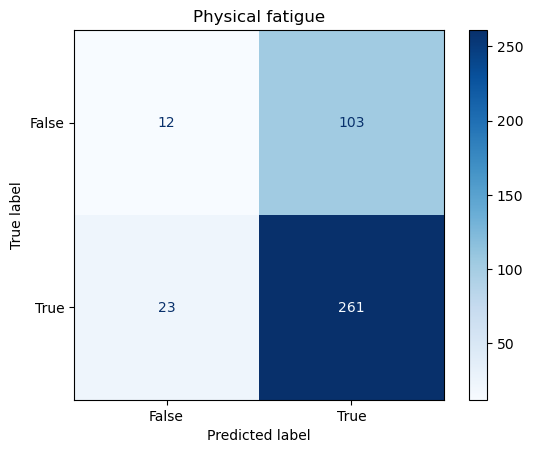

In [82]:
# classification metrics
# predict
y_test_pred = np.round(model.predict(test_batch_generator))

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1 = f1_score(y_pred=y_test_pred, y_true=y_test)
recall = recall_score(y_pred=y_test_pred, y_true=y_test)
precision = precision_score(y_pred=y_test_pred, y_true=y_test)
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy:{balanced_accuracy}\n'
      f'f1: {f1}\n'
      f'recall: {recall}\n'
      f'precision: {precision}')